In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils


# --- Hyperparameters ---
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 30
BETA = 2000  # Weight on reconstruction loss
LOAD_MODEL = False
DEVICE = "cuda"

In [ ]:
import kagglehub

# Download latest version
DATA_PATH = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", DATA_PATH)

Path to dataset files: /root/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


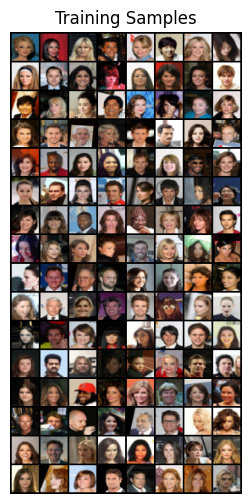

In [ ]:
# Transforms: resize to 32x32 and normalize to [0,1]
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to 32x32
    transforms.ToTensor(),  # Convert image to tensor with values in [0, 1]
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Dataset & DataLoader
train_dataset = datasets.ImageFolder(
    root=os.path.dirname(DATA_PATH),  # Folder containing subfolder "img_align_celeba"
    transform=transform
)
# NB: If you have a specific folder structure, adjust accordingly

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# Utility: show a batch of faces
def show_batch(images, title=""):
    grid_img = utils.make_grid(images, nrow=8)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis("off")
    plt.show()

# Test: Show a sample batch
data_iter = iter(train_loader)
images, _ = next(data_iter)
show_batch(images, title="Training Samples")

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim

        self.net = nn.Sequential(
            nn.Conv2d(CHANNELS, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES), #Batch normalisation
            nn.LeakyReLU(0.2, inplace=True), #activation functuon

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES), #Batch normalisation
            nn.LeakyReLU(0.2, inplace=True),  #activation functuon

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES), #Batch normalisation
            nn.LeakyReLU(0.2, inplace=True),  #activation functuon

            nn.Conv2d(NUM_FEATURES, NUM_FEATURES, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Flatten + produce mu & logvar
        # The output shape must be found dynamically
        # Hardcode if you know the shape after 4 conv layers
        # If IMAGE_SIZE=32 & 4 strided layers of stride=2 => output is 2x2
        self.flatten = nn.Flatten()
        # 2x2 out => size is (NUM_FEATURES * 2 * 2) = 128 * 2 * 2
        fc_in_features = NUM_FEATURES * (IMAGE_SIZE // 2**4) ** 2
        self.mu = nn.Linear(fc_in_features, z_dim)
        self.logvar = nn.Linear(fc_in_features, z_dim)

    def forward(self, x):
        x = self.net(x)
        x = self.flatten(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return mu, logvar


In [ ]:
class Sampling(nn.Module):
    def forward(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)    # Sample noise from a normal distribution
        return mu + std * eps

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.z_dim = z_dim

        # Reverse of flatten
        fc_out_features = NUM_FEATURES * (IMAGE_SIZE // 2**4) ** 2
        self.fc = nn.Sequential(
            nn.Linear(z_dim, fc_out_features),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.deconv = nn.Sequential(
            # Reshape => (N, NUM_FEATURES, 2, 2) if 4 strided layers used
            # We'll reshape in forward()

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, NUM_FEATURES, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(NUM_FEATURES),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(NUM_FEATURES, CHANNELS, 3, stride=2, padding=1, output_padding=1),
            # Output: (CHANNELS, 32, 32)
            nn.Sigmoid()  # since we want [0,1] output
        )

    def forward(self, z):
        x = self.fc(z)
        # Reshape -> (N, NUM_FEATURES, 2, 2)
        x = x.view(-1, NUM_FEATURES, (IMAGE_SIZE // 2**4), (IMAGE_SIZE // 2**4))
        x = self.deconv(x)
        return x


In [ ]:
class VAE(nn.Module):
    def __init__(self, z_dim=Z_DIM):
        super().__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        self.sampling = Sampling()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.sampling(mu, logvar)
        recon = self.decoder(z)
        return mu, logvar, recon, z

In [ ]:
def vae_loss_fn(x, recon, mu, logvar, beta=BETA):
    """
    x, recon: shape (N, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    mu, logvar: shape (N, Z_DIM)
    """
    # 1) Reconstruction Loss (MSE or BCE)
    # - Following your TF code => MSELoss with a BETA factor
    recon_loss = F.mse_loss(recon, x, reduction="sum")

    # 2) KL Divergence
    # kl_loss ~ -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), dim=1)
    kl_loss = kl / x.size(0)

    total_loss = recon_loss + kl_loss * beta

    return total_loss, recon_loss, kl_loss

# if LOAD_MODEL and os.path.exists("./models/vae.pt"):
#     print("Loading existing model...")
#     model.load_state_dict(torch.load("./models/vae.pt"))

In [ ]:
model = VAE(z_dim=Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(EPOCHS):
    model.train()
    total_loss_val = 0.0
    total_rec_val = 0.0
    total_kl_val = 0.0

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(DEVICE)
        optimizer.zero_grad()

        mu, logvar, recon, _ = model(x)
        loss, rec_loss, kl_loss = vae_loss_fn(x, recon=recon, mu=mu, logvar=logvar, beta=BETA)

        loss.backward()
        optimizer.step()

        total_loss_val += loss.item()
        total_rec_val += rec_loss.item()
        total_kl_val += kl_loss.item()

    avg_loss = total_loss_val / len(train_loader)
    avg_rec = total_rec_val / len(train_loader)
    avg_kl = total_kl_val / len(train_loader)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Loss: {avg_loss:.4f} | Recon: {avg_rec:.4f} | KL: {avg_kl:.4f}")

RuntimeError: grad can be implicitly created only for scalar outputs